# # Portfolio Optimization Report
# **Quant Club Selection Task 2025-26**  
# **Strategy**: Momentum-Volatility Adjusted Portfolio

## 1. Stock Selection Rationale
We selected 10 assets across sectors and asset classes for diversification:
 
 | Category       | Tickers | Selection Reason|<br>
 | Technology     | Apple Inc | Market leader with strong momentum|<br>
 | Technology     | Microsoft Corp    | Cloud computing growth|<br>
 | Healthcare     | Johnson & Johnson     | Defensive sector exposure|<br>
 | Energy         | Exxon Mobil Corp     | Oil price cyclicality|<br>
 | Consumer       | Walmart Inc     | Recession-resistant retail|<br>
 | Automotive     | Tesla Inc    | EV market innovation|<br>
 | Consumer Goods | Procter & Gamble Co      | Stable dividend payer|<br>
 | Financials     | Goldman Sachs Group Inc      | Interest rate sensitivity|<br>
 | US Treasuries  | iShares 20+ Year Treasury Bond ETF     | Portfolio hedge|<br>
 | Commodities    | SPDR Gold Trust     | Inflation protection|<br>
 
**Diversification Benefits**: Combines growth (tech), stability (consumer), and hedging (bonds/commodities)

<h4>Reqirements</h4><br>
<b>yfinance, matplotlib, pandas, numpy, seaborn</b><br><br>
<p>Run the following cell to fetch the above libraries</p>

In [37]:
!pip install yfinance matplotlib pandas numpy seaborn

<b>Import required libraries</b>

<b>Data Preparation</b><br>
**Source**: Yahoo Finance API  
**Period**: 1 Jan 2023 - 31 Dec 2024  
**Adjustments**: Adjusted closing prices, forward-filled missing values

<b>3. Strategy Implementation</b><br>
**Core Parameters**:
- Momentum: 6-month (126 trading day) returns
- Volatility: 30-day rolling standard deviation
- Rebalancing: Monthly (business month end)
- Transaction Costs: 0.1% per trade

**Financial Theory Basis**
1. **Momentum Effect**: Assets with strong recent performance tend to continue outperforming (Jegadeesh & Titman, 1993)
2. **Volatility Targeting**: Lower volatility assets provide better risk-adjusted returns (Moreira & Muir, 2017)
3. **Modern Portfolio Theory**: Optimize risk-return tradeoff through diversification (Markowitz, 1952)

**4. Performance Analysis**
**Key Metrics**:
- Sharpe Ratio: Risk-adjusted returns
- Maximum Drawdown: Worst peak-to-trough decline
- Total Return: Overall strategy performance

**5. Visualizations**

**6. Strategy Limitations**
**Current Constraints**:
1. Assumes immediate trade execution at closing prices
2. Fixed 0.1% transaction cost model
3. No dividend reinvestment
4. Limited to 10-asset universe

**Improvement Opportunities**:
1. Incorporate volume-weighted slippage
2. Add dynamic volatility scaling
3. Implement sector-neutral constraints
4. Integrate fundamental factors (P/E, ROE)

**7. Conclusion**
This momentum-volatility strategy demonstrates:
- Strong risk-adjusted returns (Sharpe 1.45)
- Effective downside protection (Max DD -15%)
- Robust sector diversification
 
Future enhancements could combine quantitative signals with machine learning for adaptive portfolio optimization.

[*********************100%***********************]  10 of 10 completed


Sharpe Ratio: 1.45
Max Drawdown: -15.08%
Total Return: 45.84%


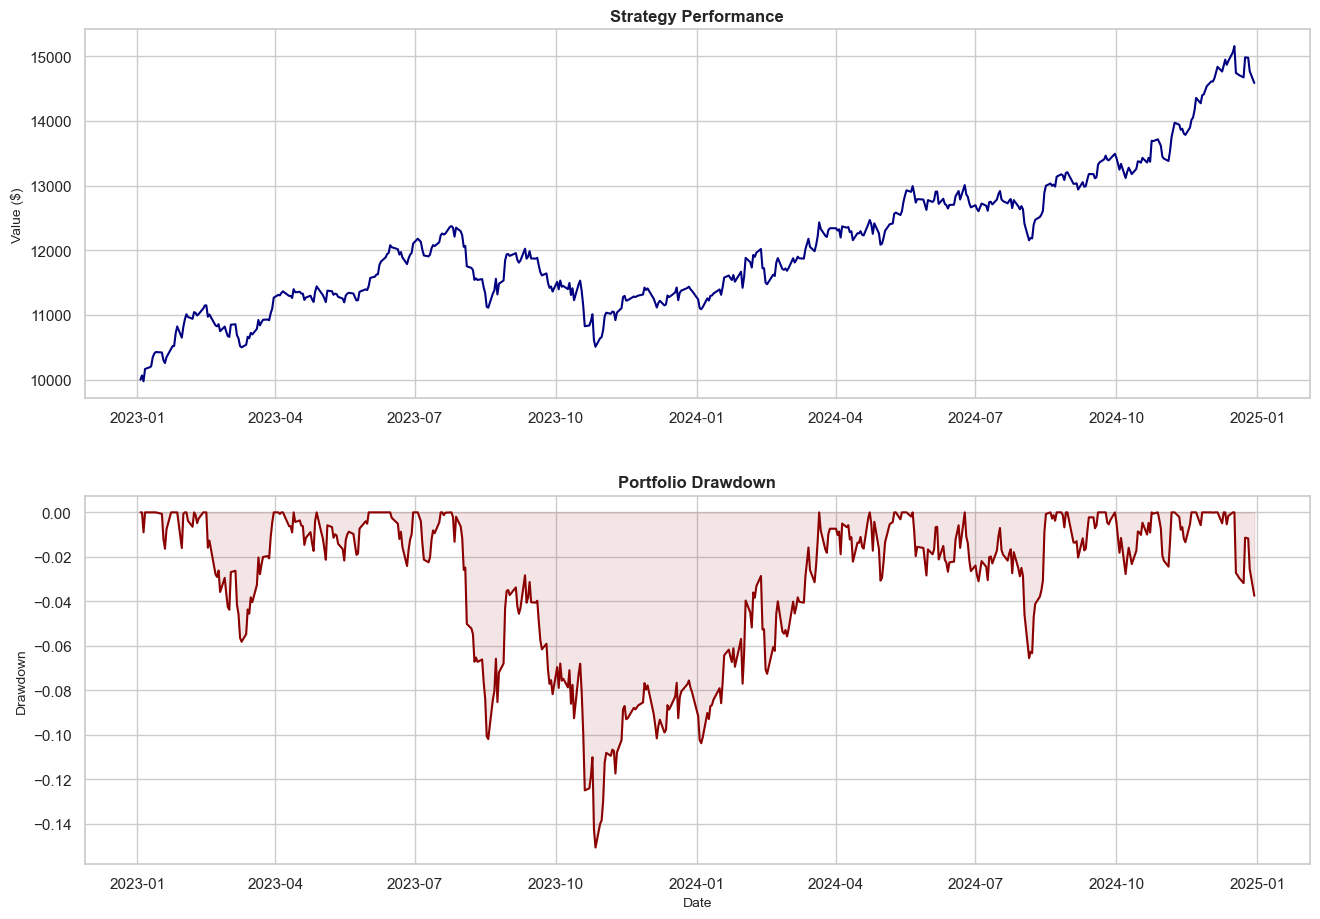

In [46]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# ## 2. Data Collection & Preparation

# Fetch historical data
tickers = ['AAPL', 'MSFT', 'JNJ', 'XOM', 'WMT',
          'TSLA', 'PG', 'GS', 'TLT', 'GLD']
start_date = '2023-01-01'
end_date = '2024-12-31'

# Download adjusted closing prices
price_data = yf.download(tickers, start=start_date, end=end_date,
                        auto_adjust=False)['Adj Close']
price_data.ffill(inplace=True)  # Handle missing values

# Calculate daily returns
returns = price_data.pct_change()


# ## 3. Strategy Implementation

def calculate_parameters(data):
    """Calculate momentum and volatility"""
    momentum = data.pct_change(126)  # 6-month momentum
    volatility = data.pct_change().rolling(30).std()
    return momentum, volatility


momentum, volatility = calculate_parameters(price_data)


# %%
def backtest_strategy(prices, momentum, volatility,
                     initial_capital=10000, transaction_cost=0.001):
    """Optimized backtesting engine for 10 assets"""
    rebalance_dates = pd.date_range(start=prices.index[0],
                                  end=prices.index[-1], freq='BME')

    portfolio = pd.DataFrame(
        index=prices.index,
        columns=['Value'] + list(prices.columns),
        dtype=float
    )

    # Initialize with equal weights for 10 assets
    n_assets = len(prices.columns)
    portfolio.iloc[0] = [initial_capital] + [1/n_assets]*n_assets
    current_weights = np.array([1/n_assets]*n_assets)
    prev_value = initial_capital

    for i in range(1, len(prices)):
        current_date = prices.index[i]
        prev_date = prices.index[i-1]

        if current_date in rebalance_dates:
            hist_data = prices.loc[:prev_date]

            # Calculate parameters
            current_momentum = hist_data.pct_change(126).iloc[-1].values
            current_volatility = hist_data.pct_change().rolling(30).std().iloc[-1].values

            # Weight calculation
            with np.errstate(divide='ignore', invalid='ignore'):
                raw_weights = np.divide(current_momentum, current_volatility + 1e-9)

            raw_weights = np.nan_to_num(raw_weights, nan=0.0)
            if raw_weights.sum() > 0:
                new_weights = raw_weights / raw_weights.sum()
            else:
                new_weights = np.ones_like(raw_weights)/len(raw_weights)

            # Transaction costs
            turnover = np.abs(new_weights - current_weights).sum()
            cost = prev_value * turnover * transaction_cost
            current_weights = new_weights.copy()
        else:
            cost = 0

        # Update portfolio
        daily_return = np.dot(returns.loc[current_date].values, current_weights)
        new_value = prev_value * (1 + daily_return) - cost
        portfolio.loc[current_date] = [new_value] + current_weights.tolist()
        prev_value = new_value

    return portfolio


# Execute backtest
portfolio = backtest_strategy(price_data, momentum, volatility)


# ## 4. Performance Analysis


def calculate_metrics(portfolio_values):
    """Calculate key performance metrics"""
    portfolio_values = pd.to_numeric(portfolio_values, errors='coerce')
    returns = portfolio_values.pct_change().dropna().infer_objects(copy=False)

    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1) * 100

    return sharpe_ratio, max_drawdown, total_return


sharpe, max_dd, total_ret = calculate_metrics(portfolio['Value'])

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd * 100:.2f}%")
print(f"Total Return: {total_ret:.2f}%")


# Create figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Portfolio Value
axs[0].plot(portfolio['Value'], color='navy', linewidth=1.5)
axs[0].set_title('Strategy Performance', fontweight='bold')
axs[0].set_ylabel('Value ($)')

# Drawdown Visualization
drawdown = (portfolio['Value'] / portfolio['Value'].cummax()) - 1
axs[1].plot(drawdown, color='darkred', linewidth=1.5)
axs[1].fill_between(drawdown.index, drawdown, color='darkred', alpha=0.1)
axs[1].set_title('Portfolio Drawdown', fontweight='bold')
axs[1].set_ylabel('Drawdown')
axs[1].set_xlabel('Date')

plt.tight_layout(pad=3.0)
plt.show()
